## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime
import gc
from bayes_opt import BayesianOptimization
from sklearn.model_selection import TimeSeriesSplit
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = "../../Ashrae/data/"

/Users/jasminabajramovic/miniconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Load Data

In [2]:
train_df = pd.read_csv(DATA_PATH + 'train.csv')

train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

building_df = pd.read_csv(DATA_PATH + 'building_metadata.csv')
weather_df = pd.read_csv(DATA_PATH + 'weather_train.csv')

test_df = pd.read_csv(DATA_PATH + 'test.csv')
weather_test_df = pd.read_csv(DATA_PATH + 'weather_test.csv')

## Fill weather missing data

Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

In [3]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.weekday
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    weather_df["hour"] = weather_df["datetime"].dt.hour
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime', 'week'],axis=1)
        
    return weather_df

# Reduce memory usage

Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

In [4]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Features engineering

In [5]:
def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["weekend"] = df["timestamp"].dt.weekday
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [6]:
weather_df = fill_weather_dataset(weather_df)
weather_test_df = fill_weather_dataset(weather_test_df)

In [7]:
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

test_df = reduce_mem_usage(test_df, use_float16 = True)
weather_test_df = reduce_mem_usage(weather_test_df, use_float16 = True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.24 MB
Decreased by 57.4%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 12.87 MB
Memory usage after optimization is: 3.06 MB
Decreased by 76.2%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 25.66 MB
Memory usage after optimization is: 6.11 MB
Decreased by 76.2%


## Merge Data

We need to add building and weather information into training dataset.

In [8]:
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])

test_df = test_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
test_df = test_df.merge(weather_test_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])

del weather_df, weather_test_df
gc.collect()

20

In [9]:
train_df = features_engineering(train_df)
test_df = features_engineering(test_df)

In [10]:
train_df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,day,month,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend,is_holiday
0,105,0,23.303600,1,0,10.832181,4,1,3.800781,0.0,2.400391,0.041656,0,4,0
1,106,0,0.374600,1,0,8.589514,4,1,3.800781,0.0,2.400391,0.041656,0,4,0
2,106,3,0.000000,1,0,8.589514,4,1,3.800781,0.0,2.400391,0.041656,0,4,0
3,107,0,175.184006,1,0,11.487946,4,1,3.800781,0.0,2.400391,0.041656,0,4,0
4,108,0,91.265297,1,0,11.309352,4,1,3.800781,0.0,2.400391,0.041656,0,4,0


## Features & Target Variables

In [11]:
target = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)

del train_df
gc.collect()

0

In [12]:
nsplits = 3
folds = TimeSeriesSplit(nsplits)

In [26]:
params = {"boosting": "gbdt",
          'application':'regression',
          'num_iterations':1000, 
          'early_stopping_round':200, 
          'metric':'rmse',
          'num_leaves': 1000,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.8,
          'max_depth': 10,
          'lambda_l1': 2.,
          'lambda_l2': 5.,
          'min_split_gain': 0.001,
          'min_child_weight': 5.,
          'learning_rate' : 0.1}

In [27]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "is_holiday", "weekend", "day", "month", "hour"]

X_train = features
y_train = target

pred = np.zeros(len(test_df))

df_fimp = pd.DataFrame()
for tr_idx,va_idx in folds.split(X_train,y_train):
    X_half_1 = X_train.iloc[tr_idx]
    y_half_1 = y_train.iloc[tr_idx]
    X_half_2 = X_train.iloc[va_idx]
    y_half_2 = y_train.iloc[va_idx]

    d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
    d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

    print("Building model with first half and validating on second half:")
    model_half = lgb.train(params, train_set=d_half_1, num_boost_round=300, valid_sets=[d_half_1,d_half_2], verbose_eval=100, early_stopping_rounds=50)
    gc.collect()
    pred += np.expm1(model_half.predict(test_df, num_iteration=model_half.best_iteration)) / nsplits
    
    df_fimp_1 = pd.DataFrame()
    df_fimp_1["feature"] = X_train.columns.values
    df_fimp_1["importance"] = model_half.feature_importance()
    
    df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
    del model_half
    gc.collect()

Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.614205	valid_1's rmse: 1.2794
[200]	training's rmse: 0.556311	valid_1's rmse: 1.26861
[300]	training's rmse: 0.525372	valid_1's rmse: 1.26976
[400]	training's rmse: 0.50301	valid_1's rmse: 1.27469
Early stopping, best iteration is:
[213]	training's rmse: 0.551299	valid_1's rmse: 1.26822
Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.698847	valid_1's rmse: 1.36738
[200]	training's rmse: 0.640977	valid_1's rmse: 1.40009
Early stopping, best iteration is:
[31]	training's rmse: 0.90921	valid_1's rmse: 1.25241
Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.742332	valid_1's rmse: 1.09618
[200]	training's rmse: 0.671961	valid_1's rmse: 1.11659
[3

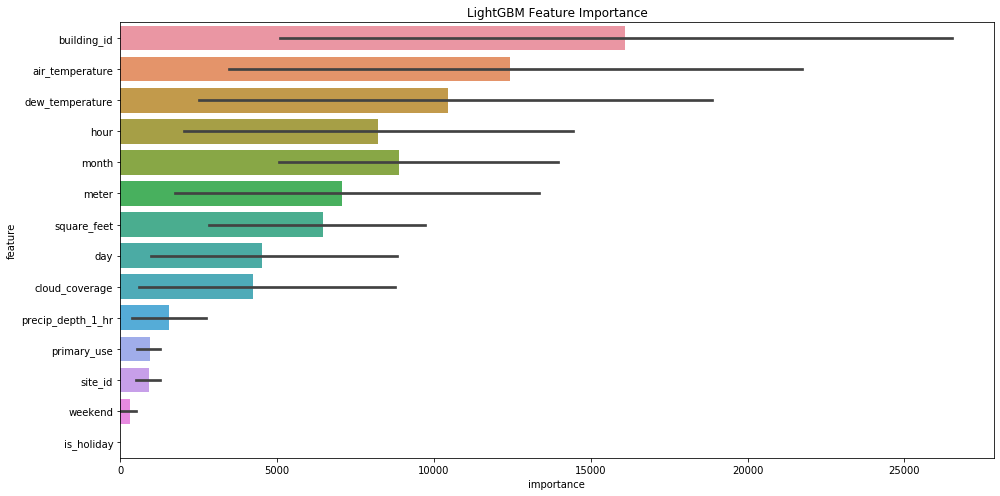

In [32]:
plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [35]:
sample = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [40]:
sample['meter_reading'] = pred

In [43]:
sample.columns

Index(['row_id', 'meter_reading'], dtype='object')

In [44]:
sample.to_csv('submission.csv', index = False)

**LB Score: 2.64**

In [45]:
features.head()

,building_id,meter,site_id,primary_use,square_feet,day,month,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend,is_holiday
0,105,0,1,0,10.832181,4,1,3.800781,0.0,2.400391,0.041656,0,4,0
1,106,0,1,0,8.589514,4,1,3.800781,0.0,2.400391,0.041656,0,4,0
2,106,3,1,0,8.589514,4,1,3.800781,0.0,2.400391,0.041656,0,4,0
3,107,0,1,0,11.487946,4,1,3.800781,0.0,2.400391,0.041656,0,4,0
4,108,0,1,0,11.309352,4,1,3.800781,0.0,2.400391,0.041656,0,4,0


In [13]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "max_depth": -1,
    "num_leaves": 1000,
    "learning_rate": 0.1,
    "feature_fraction": 0.95,
    "reg_lambda": 2,
    "max_bin": 550,
    "metric": "rmse",
    "early_stopping_round":50    
}

categorical_features = ["building_id", "site_id", "meter", "primary_use", "is_holiday", "weekend", "day", "month", "hour"]

X_train = features
y_train = target

pred = np.zeros(len(test_df))

df_fimp = pd.DataFrame()
for tr_idx,va_idx in folds.split(X_train,y_train):
    X_half_1 = X_train.iloc[tr_idx]
    y_half_1 = y_train.iloc[tr_idx]
    X_half_2 = X_train.iloc[va_idx]
    y_half_2 = y_train.iloc[va_idx]

    d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
    d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

    print("Building model with first half and validating on second half:")
    model_half = lgb.train(params, train_set=d_half_1, num_boost_round=300, valid_sets=[d_half_1,d_half_2], verbose_eval=100, early_stopping_rounds=50)
    gc.collect()
    pred += np.expm1(model_half.predict(test_df, num_iteration=model_half.best_iteration)) / nsplits
    
    df_fimp_1 = pd.DataFrame()
    df_fimp_1["feature"] = X_train.columns.values
    df_fimp_1["importance"] = model_half.feature_importance()
    
    df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
    del model_half
    gc.collect()

Building model with first half and validating on second half:
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.502515	valid_1's rmse: 1.28803
Early stopping, best iteration is:
[81]	training's rmse: 0.520249	valid_1's rmse: 1.28686
Building model with first half and validating on second half:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's rmse: 0.87346	valid_1's rmse: 1.28787
Building model with first half and validating on second half:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's rmse: 0.714391	valid_1's rmse: 1.12064


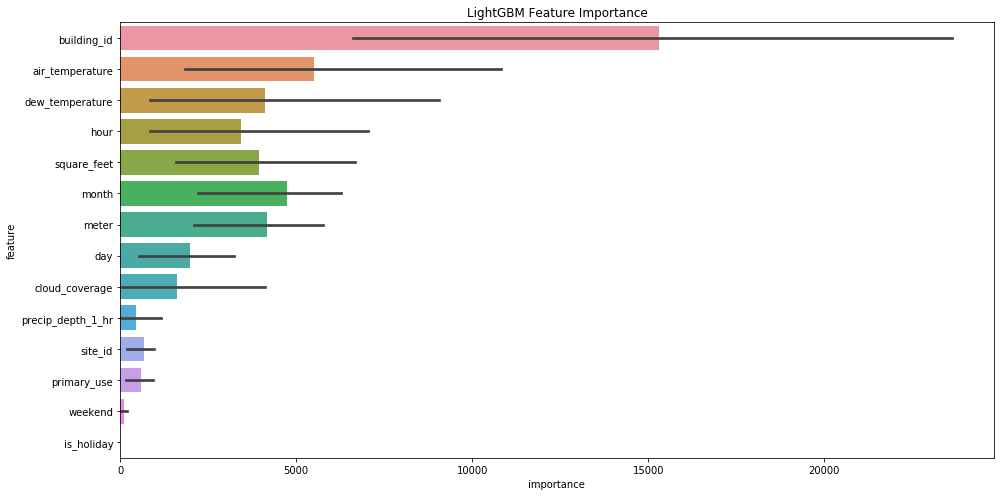

In [14]:
plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [21]:
sample = pd.read_csv(DATA_PATH + 'sample_submission.csv')
sample['meter_reading'] = pred
sample.head()

,row_id,meter_reading
0,0,271.974940
1,1,189.507949
2,2,203.287001
3,3,307.572059
4,4,286.101246


In [22]:
sample.shape

(41697600, 2)

In [23]:
sample.to_csv('submission2.csv', index=False)

**LB score: 2.51**

In [24]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 500,
    "learning_rate": 0.05,
    "feature_fraction": 0.7,
    "metric": "rmse",
    "early_stopping_round":50    
}

categorical_features = ["building_id", "site_id", "meter", "primary_use", "is_holiday", "weekend", "day", "month", "hour"]

X_train = features
y_train = target

pred = np.zeros(len(test_df))

df_fimp = pd.DataFrame()
for tr_idx,va_idx in folds.split(X_train,y_train):
    X_half_1 = X_train.iloc[tr_idx]
    y_half_1 = y_train.iloc[tr_idx]
    X_half_2 = X_train.iloc[va_idx]
    y_half_2 = y_train.iloc[va_idx]

    d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
    d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

    print("Building model with first half and validating on second half:")
    model_half = lgb.train(params, train_set=d_half_1, num_boost_round=10000, valid_sets=[d_half_1,d_half_2], verbose_eval=25, early_stopping_rounds=50)
    gc.collect()
    pred += np.expm1(model_half.predict(test_df, num_iteration=model_half.best_iteration)) / nsplits
    
    df_fimp_1 = pd.DataFrame()
    df_fimp_1["feature"] = X_train.columns.values
    df_fimp_1["importance"] = model_half.feature_importance()
    
    df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
    del model_half
    gc.collect()

Building model with first half and validating on second half:
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.05015	valid_1's rmse: 1.39538
[50]	training's rmse: 0.765798	valid_1's rmse: 1.29835
[75]	training's rmse: 0.67496	valid_1's rmse: 1.28175
[100]	training's rmse: 0.630857	valid_1's rmse: 1.27529
[125]	training's rmse: 0.59965	valid_1's rmse: 1.26988
[150]	training's rmse: 0.580851	valid_1's rmse: 1.26622
[175]	training's rmse: 0.568188	valid_1's rmse: 1.26612
[200]	training's rmse: 0.558595	valid_1's rmse: 1.26553
[225]	training's rmse: 0.551179	valid_1's rmse: 1.26517
[250]	training's rmse: 0.545691	valid_1's rmse: 1.26567
[275]	training's rmse: 0.539973	valid_1's rmse: 1.26502
[300]	training's rmse: 0.535545	valid_1's rmse: 1.26474
[325]	training's rmse: 0.531817	valid_1's rmse: 1.26441
[350]	training's rmse: 0.528441	valid_1's rmse: 1.26513
Early stopping, best iteration is:
[316]	training's rmse: 0.53277	valid_1's rmse: 1.26426
Building 

In [25]:
sample = pd.read_csv(DATA_PATH + 'sample_submission.csv')
sample['meter_reading'] = pred
sample.head()

,row_id,meter_reading
0,0,60.038153
1,1,27.552297
2,2,92.048333
3,3,32.575986
4,4,33.618006


In [26]:
sample.to_csv('submission3.csv', index=False)

**LB score: 2.34**